In [1]:
import numpy as np
import pandas as pd
#pd.options.display.float_format = '{:2f}'.format

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from io import StringIO
from IPython.display import Image, display
import pydotplus

In [2]:
!ls

 file4k.html	    README.md				   tree.png
 img		   'Real estate valuation data set.xlsx'
 price_by_geo.jpg   real_state.ipynb


In [3]:
# Carga de los datos
data = pd.read_excel("Real estate valuation data set.xlsx")

## Data Preparation

In [4]:
data.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [5]:
# Renaming columns
data.columns = ['no','transaction_date','house_age','distance_to_station','n_stores','latitude','longitude','price']

# Dropping column 'no'
data.drop('no', axis=1, inplace=True)

# Converting dtype of 'transaction_date'
data['transaction_date'] = pd.to_datetime(data['transaction_date'], format='%Y/%m/%d')

## Exploratory Data Analysis

In [6]:
# Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   transaction_date     414 non-null    datetime64[ns]
 1   house_age            414 non-null    float64       
 2   distance_to_station  414 non-null    float64       
 3   n_stores             414 non-null    int64         
 4   latitude             414 non-null    float64       
 5   longitude            414 non-null    float64       
 6   price                414 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 22.8 KB


In [7]:
# Number of unique values by feature
data.nunique()

transaction_date         2
house_age              236
distance_to_station    259
n_stores                11
latitude               234
longitude              232
price                  270
dtype: int64

In [8]:
# 'transaction_date' review
data['transaction_date'].unique()

# Dropping 'transaction_date' from dataset
data.drop('transaction_date', axis=1, inplace=True)

### Distribution of price

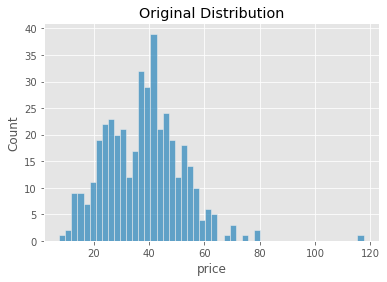

(<AxesSubplot:title={'center':'Original Distribution'}, xlabel='price', ylabel='Count'>,
 None)

In [9]:
# Original price distribution
plt.title('Original Distribution')
sns.histplot(data.price, bins=50), plt.show()

In [10]:
# Converting price distribution to lognormal
data['price_logs'] = np.log1p(data.price)

# Deleting old price from dataset
del data['price']

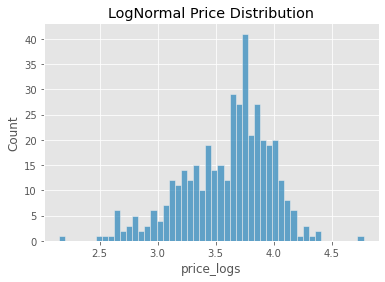

(<AxesSubplot:title={'center':'LogNormal Price Distribution'}, xlabel='price_logs', ylabel='Count'>,
 None)

In [11]:
# Original price distribution
plt.title('LogNormal Price Distribution')
sns.histplot(data['price_logs'], bins=50), plt.show()

### Missing Values

In [12]:
data.isnull().sum()

house_age              0
distance_to_station    0
n_stores               0
latitude               0
longitude              0
price_logs             0
dtype: int64

### Visualización de datos geográficos

Contamos con datos geográficos(longitud, latitud). Los visualizamos para buscar patrones.  


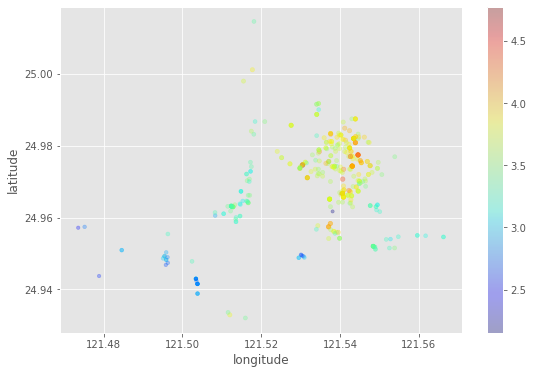

In [13]:
# By price
fig, ax = plt.subplots(1,1)
data.plot(kind='scatter', x='longitude', y='latitude', alpha=.3,
          s=data['price_logs']*5,c=data['price_logs'], cmap=plt.get_cmap('jet'), colorbar=True,
          ax=ax, figsize=(9,6))
plt.savefig('img/price_by_geo.jpg')

Podemos observar que existe un área donde se concentran una gran cantidad de viviendas con precios medios-altos, sin embargo, en esta área se puede observar que hay instancias con valores bajos. Las vivivendas de precios más bajos, se encuentran dispersas, por lo general, alejadas del área anteriormente mencionada. 

### Correlations

In [14]:
corr_matrix = data.corr(method='spearman')
corr_matrix['price_logs'].sort_values()

distance_to_station   -0.775948
house_age             -0.281753
longitude              0.437672
latitude               0.578419
n_stores               0.617333
price_logs             1.000000
Name: price_logs, dtype: float64

Mediante el coeficiente de correlación (de Spearman), podemos resaltar que:
* La distancia hasta la estación del metro(distance_to_station) y,
* La cantidad de tiendas de conveniencias cercanas(n_store), 

están fuertemente correlacionadas con el precio de las viviendas. Más, esto no significa causalidad.

## <b>Model (Random Forest)

In [15]:
# Datos de entrada
# ================================================================
X = data
y = data.pop('price_logs')
X.head(2)

,house_age,distance_to_station,n_stores,latitude,longitude
0,32.0,84.87882,10,24.98298,121.54024
1,19.5,306.59470,9,24.98034,121.53951


In [16]:
# Separar datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=.3)

### DecisionTreeRegressor

Algoritmo de Árbol de decisión (Regresión) con parámetros por defecto.

In [17]:
# Regresor de Bosque Aleatorio
# Entrenamiento del modelo
# =====================================================================
randomf_reg = RandomForestRegressor(random_state=0)
randomf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [18]:
importancia_predictores = pd.DataFrame(
                            {'predictor': data.columns,
                             'importancia': randomf_reg.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
1,distance_to_station,0.641412
3,latitude,0.135716
0,house_age,0.109435
4,longitude,0.095669
2,n_stores,0.017769


Nuestro modelo de bosque aleatorio como el coeficiente de correlación nos indican que "distance_to_station" es la variable que mayor información nos aporta para la regresión de nuestra variable objetivo.

### Validación Cruzada (10 k-folds)

Realizo una validación cruzada de 10 k-folds para evaluar la capacidad de predicción del modelo (con los hiperparámetros por defecto).

In [19]:
# Cross-Validation
# =====================================================================
y_preds = cross_val_score(randomf_reg, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)
rf_rmse = np.sqrt(-y_preds)
print('RMSE de los 10 k-folds:')
print(rf_rmse)
print()
rf_rmse_mean = round(np.mean(rf_rmse),2)
rf_rmse_std = round(np.std(rf_rmse),2)
print(f'RMSE promedio: {rf_rmse_mean}, desviación: {rf_rmse_std}')

RMSE de los 10 k-folds:
[0.15797634 0.28694106 0.13954192 0.30966727 0.19443553 0.12977802
 0.21184362 0.1875253  0.13385354 0.21386701]

RMSE promedio: 0.2, desviación: 0.06


### Ajuste del modelo

In [20]:
modelo = RandomForestRegressor(random_state=34)     
modelo.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 34,
 'verbose': 0,
 'warm_start': False}

In [21]:
# Hiperparámetros - RandomForest
# ==========================================================================

# Método de selección de muestra
bootstrap = [True, False]
# Niveles máximos en cada árbol
max_depth = [x for x in np.arange(10, 150, step=10)]
# Cantidad de características a considerar para cada división
max_features = ['auto', 'sqrt']
# Cantidad mínima de muestras requeridas para un nodo hoja
min_samples_leaf = [x for x in np.arange(0, 30, step=5)]
# Cantidad mínimas de muestras para dividir un nodo
min_samples_split = [x for x in np.arange(0, 30, step=5)]
# Cantidad de árboles
n_estimators = [x for x in np.arange(30, 500, step=25)]

param_distributions = {
    'bootstrap'         : bootstrap,
    'max_depth'         : max_depth,
    'max_features'      : max_features,
    'min_samples_leaf'  : min_samples_leaf,
    'min_samples_split' : min_samples_split,
    'n_estimators'      : n_estimators,
}

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(estimator=modelo, 
                        param_distributions=param_distributions,
                        scoring='neg_mean_squared_error',
                        cv=10, 
                        n_jobs=-1, 
                        random_state=40)    

random_search.fit(X_train, y_train)

/home/pablo/anaconda3/envs/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pablo/anaconda3/envs/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pablo/anaconda3/envs/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/pablo/anaconda3/envs/venv/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_b

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=34),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [0, 5, 10, 15, 20,
                                                             25],
                                        'min_samples_split': [0, 5, 10, 15, 20,
                                                              25],
                                        'n_estimators': [30, 55, 80, 105, 130,
                                                         155, 180, 205, 230,
                                                         255, 280, 305, 330,
   

In [22]:
random_search.best_params_

{'n_estimators': 130,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

In [23]:
def evaluate(model, X_train, y_train):
    y_preds = cross_val_score(model, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)
    scores = np.sqrt(-y_preds)
    model_score = np.mean(scores)
    print('Model Performance')
    print('Root Mean Squared Error: {:0.4f}'.format(model_score))
    
    return model_score

In [24]:
#base_model.fit(X_train, y_train)
base_rmse = evaluate(randomf_reg, X_train, y_train)

Model Performance
Root Mean Squared Error: 0.1965


In [25]:
best_random = random_search.best_estimator_
random_rmse = evaluate(best_random, X_train, y_train)

Model Performance
Root Mean Squared Error: 0.1902


#### GridSearchCV

In [26]:
random_search.best_params_

{'n_estimators': 130,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

In [27]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators':      [i for i in np.arange(128,132)],
    'min_samples_split': [i for i in np.arange(3, 7)],
    'min_samples_leaf':  [i for i in np.arange(3, 7)],
    'max_features':      ['sqrt'],
    'max_depth':         [i for i in np.arange(108, 112)],
    'bootstrap':         [True]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [28]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits
[CV] END bootstrap=True, max_depth=108, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=128; total time=   0.3s
[CV] END bootstrap=True, max_depth=108, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=130; total time=   0.3s
[CV] END bootstrap=True, max_depth=108, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=131; total time=   0.3s
[CV] END bootstrap=True, max_depth=108, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=128; total time=   0.3s
[CV] END bootstrap=True, max_depth=108, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=130; total time=   0.3s
[CV] END bootstrap=True, max_depth=108, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=131; total time=   0.3s
[CV] END bootstrap=True, max_depth=108, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=12

[CV] END bootstrap=True, max_depth=108, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=129; total time=   0.3s
[CV] END bootstrap=True, max_depth=108, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=129; total time=   0.3s
[CV] END bootstrap=True, max_depth=108, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=131; total time=   0.3s
[CV] END bootstrap=True, max_depth=108, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=128; total time=   0.3s
[CV] END bootstrap=True, max_depth=108, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=129; total time=   0.3s
[CV] END bootstrap=True, max_depth=108, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=131; total time=   0.3s
[CV] END bootstrap=True, max_depth=108, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=128; total time=   0.3s
[CV] END bootstrap=True, max_depth=108, m

[CV] END bootstrap=True, max_depth=109, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=129; total time=   0.3s
[CV] END bootstrap=True, max_depth=109, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=130; total time=   0.3s
[CV] END bootstrap=True, max_depth=109, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=128; total time=   0.3s
[CV] END bootstrap=True, max_depth=109, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=129; total time=   0.3s
[CV] END bootstrap=True, max_depth=109, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=130; total time=   0.3s
[CV] END bootstrap=True, max_depth=109, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=128; total time=   0.3s
[CV] END bootstrap=True, max_depth=109, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=129; total time=   0.3s
[CV] END bootstrap=True, max_depth=109, m

[CV] END bootstrap=True, max_depth=109, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=128; total time=   0.3s
[CV] END bootstrap=True, max_depth=109, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=130; total time=   0.3s
[CV] END bootstrap=True, max_depth=109, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=131; total time=   0.3s
[CV] END bootstrap=True, max_depth=109, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=128; total time=   0.3s
[CV] END bootstrap=True, max_depth=109, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=130; total time=   0.3s
[CV] END bootstrap=True, max_depth=109, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=131; total time=   0.3s
[CV] END bootstrap=True, max_depth=109, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=128; total time=   0.3s
[CV] END bootstrap=True, max_depth=109, m

[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=131; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=128; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=130; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=131; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=128; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=130; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=131; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, m

[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=129; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=130; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=128; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=129; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=128; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=129; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, m

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [108, 109, 110, 111],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 4, 5, 6],
                         'min_samples_split': [3, 4, 5, 6],
                         'n_estimators': [128, 129, 130, 131]},
             verbose=2)

In [29]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 111,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 130}

### Evaluate

In [30]:
# Modelo final 
final_model =grid_search.best_estimator_

[CV] END bootstrap=True, max_depth=111, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=131; total time=   0.3s
[CV] END bootstrap=True, max_depth=111, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=129; total time=   0.3s
[CV] END bootstrap=True, max_depth=111, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=130; total time=   0.3s
[CV] END bootstrap=True, max_depth=111, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=131; total time=   0.3s
[CV] END bootstrap=True, max_depth=111, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=129; total time=   0.3s
[CV] END bootstrap=True, max_depth=111, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=130; total time=   0.3s
[CV] END bootstrap=True, max_depth=111, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=131; total time=   0.3s
[CV] END bootstrap=True, max_depth=111, m